# Treinamento de Rede LSTM para classificação

## Libs

In [90]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from textwrap import fill
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import kagglehub

import gensim.downloader as gd

import torch
from torch import nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

tqdm.pandas()

## Funções

In [91]:
def preprocess_text_to_embedding(text: str, embedding_model, max_seq_length: int = 200) -> torch.Tensor:
    # Remove HTML tags and non-alphanumeric characters
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    # Convert to lowercase and split into words
    text = text.lower()
    words = text.split()
    
    # Truncate to max sequence length
    words = words[:max_seq_length]
    
    # Convert words to embeddings, ignoring words not in the embedding model
    embds = torch.tensor(np.array([embedding_model[w] for w in words if w in embedding_model]))
    
    return embds

## Preparação do Dataset

In [92]:
path = kagglehub.dataset_download("hgultekin/bbcnewsarchive")
path = Path(path)

print(f"Diretório principal: {path}")

print("- Arquivos e diretórios filhos:")
for file in path.iterdir():
    print(f"\t{file.name}")

Diretório principal: /home/pioneiro/.cache/kagglehub/datasets/hgultekin/bbcnewsarchive/versions/1
- Arquivos e diretórios filhos:
	bbc-news-data.csv


In [93]:
data = pd.read_csv(path / 'bbc-news-data.csv', sep='\t')
data.sample(5)

,category,filename,title,content
660,entertainment,151.txt,Eminem secret gig venue revealed,Rapper Eminem is to play an intimate gig in L...
874,entertainment,365.txt,Tarantino to direct CSI episode,Film director Quentin Tarantino is to direct ...
1545,sport,233.txt,Redknapp poised for Saints,Southampton are set to unveil Harry Redknapp ...
944,politics,049.txt,Clarke to press on with ID cards,New Home Secretary Charles Clarke has vowed t...
1886,tech,063.txt,Digital guru floats sub-$100 PC,"Nicholas Negroponte, chairman and founder of ..."


In [94]:
len(data)

2225

## Vizualização dos dados

/tmp/ipykernel_4166973/3927542740.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


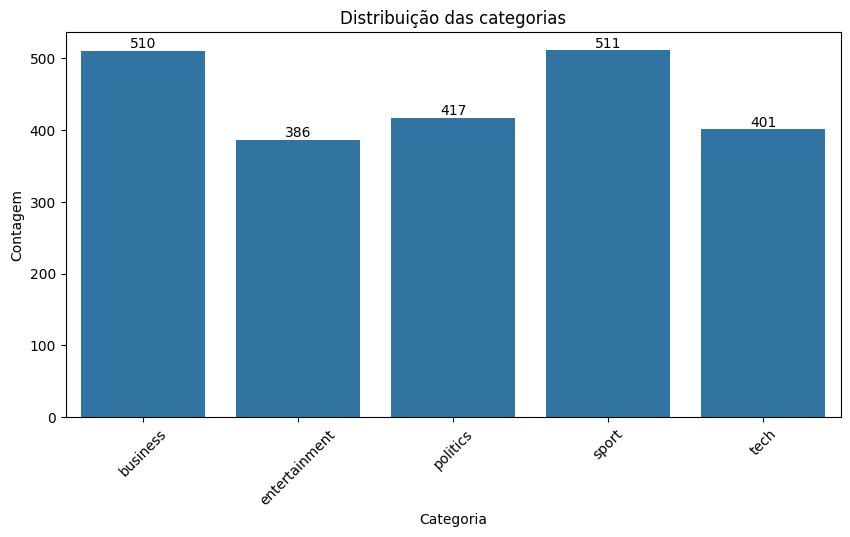

In [97]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.countplot(x='category', data=data, ax=ax)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

ax.set_title('Distribuição das categorias')
ax.set_xlabel('Categoria')
ax.set_ylabel('Contagem')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.show()

## Embeddings

In [98]:
gensim_embedding_model = gd.load("glove-twitter-50")

In [99]:
text = data.sample(1)["content"].values[0]

embds = preprocess_text_to_embedding(text=text, embedding_model=gensim_embedding_model)

print(f"Texto: {fill(text)}")
print(f"\nEmbeddings shape: {embds.shape}")

Texto:  Marat Safin suffered a shock loss to unseeded Nicolas Kiefer in round
one of the Dubai Tennis Championships.  Playing his first match since
winning the Australian Open, Safin showed some good touches but was
beaten 7-6 (7-2) 6-4 by the in-form Kiefer. The German got on top in
the first-set tie-break, striking a sweet forehand to win the first
point against serve. And he maintained the momentum early in the
second set, breaking the Russian with the help of an inspired volley.
Spain's Feliciano Lopez lined up a second round clash with Andre
Agassi by beating Thailand's Paradorn Srichaphan. Lopez, who lost in
three sets to Roger Federer in last year's final, won 6-2 3-6 6-3.
Former champion Fabrice Santoro of France was beaten 6-3 6-0 by sixth
seeded Russian Nikolay Davydenko. There were also wins for two other
Russians, Igor Andreev and seventh seed Mikhail Youzhny.

Embeddings shape: torch.Size([141, 50])


Pré-processando todas as linhas do dataset.

In [100]:
X = [
    preprocess_text_to_embedding(
        text=t,
        embedding_model=gensim_embedding_model
    ) for t in data["content"]
]

print(f"Total de amostras processadas: {len(X)}")

Total de amostras processadas: 2225


## Labels

In [101]:
encoder = LabelEncoder()

y = encoder.fit_transform(data["category"])
y = y.astype(np.int64)
y = torch.tensor(y)

y

tensor([0, 0, 0,  ..., 4, 4, 4])

## Dataset e Dataloader

In [102]:
x_padded = pad_sequence(X, batch_first=True)
x_padded.shape

torch.Size([2225, 200, 50])

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x_padded, y, test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1)

train_ds = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

val_ds = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_ds, batch_size=64)

test_ds = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_ds, batch_size=64)

print(f"Total de treino: {len(train_ds)}")
print(f"Total de validação: {len(val_ds)}")
print(f"Total de teste: {len(test_ds)}")

Total de treino: 1602
Total de validação: 178
Total de teste: 445


## Model

In [104]:
class Model(nn.Module):
    def __init__(self, num_classes: int = 2):
        super().__init__()

        hidden_size = 32

        self.lstm = nn.LSTM(
            input_size=50,     # embedding size
            hidden_size=hidden_size,
            bidirectional=False,
            batch_first=True,
        )

        self.dropout = nn.Dropout(p=0.5)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, sequence):
        _, (hidden, cell) = self.lstm(sequence)
        
        dropped = self.dropout(hidden.squeeze(0))
        
        prediction = self.fc(dropped)
        
        return prediction

num_classes = len(encoder.classes_)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

net = Model(num_classes=num_classes).to(device)

Using device: cuda


## Treinamento e avaliação

In [105]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

history = []
n_epochs = 240

best_val_loss = float('inf')
best_model_path = 'best_model.pth'

# repete por um número de épocas
for epoch in range(n_epochs):
    # epoca de treinamento: itera sobre os batches do conjunto de treino
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    running_loss /= len(train_ds)

    # avaliação no conjunto de teste
    net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = net(inputs)
            
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()

    val_loss /= len(val_ds)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(net.state_dict(), best_model_path)

    history.append([running_loss, val_loss])

    if epoch % max(1, n_epochs // 20)  == 0:
        print(f'[{epoch + 1}] loss: {running_loss:.4f} val loss: {val_loss:.4f}')

print('Finished Training')

[1] loss: 0.0263 val loss: 0.0269
[13] loss: 0.0159 val loss: 0.0175
[25] loss: 0.0130 val loss: 0.0136
[37] loss: 0.0117 val loss: 0.0134
[49] loss: 0.0108 val loss: 0.0122
[61] loss: 0.0101 val loss: 0.0108
[73] loss: 0.0073 val loss: 0.0102
[85] loss: 0.0071 val loss: 0.0090
[97] loss: 0.0056 val loss: 0.0079
[109] loss: 0.0051 val loss: 0.0073
[121] loss: 0.0042 val loss: 0.0071
[133] loss: 0.0095 val loss: 0.0089
[145] loss: 0.0067 val loss: 0.0083
[157] loss: 0.0037 val loss: 0.0068
[169] loss: 0.0031 val loss: 0.0058
[181] loss: 0.0022 val loss: 0.0077
[193] loss: 0.0034 val loss: 0.0066
[205] loss: 0.0022 val loss: 0.0067
[217] loss: 0.0016 val loss: 0.0065
[229] loss: 0.0014 val loss: 0.0064
Finished Training


Evolução da **função de perda** nos conjuntos de treino e validação ao longo do treinamento. 

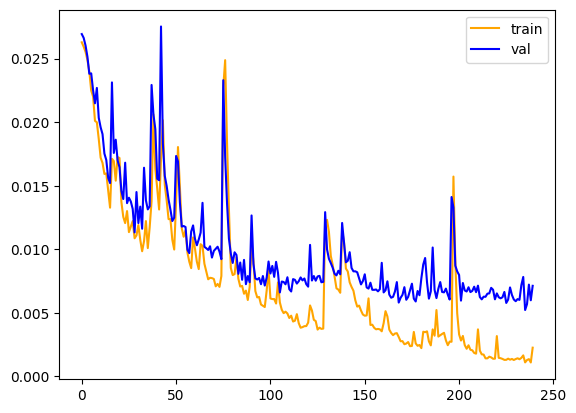

In [106]:
history = np.array(history)

plt.plot(history[:, 0], '-', color='orange', label='train')
plt.plot(history[:, 1], '-', color='blue', label='val')
plt.legend()

## Teste

In [115]:
y_true = []
y_pred = []

best_model = Model(num_classes=num_classes).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = best_model(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=encoder.classes_)) 

               precision    recall  f1-score   support

     business       0.89      0.89      0.89       102
entertainment       0.92      0.96      0.94        76
     politics       0.84      0.89      0.86        80
        sport       0.98      0.96      0.97       115
         tech       0.93      0.86      0.89        72

     accuracy                           0.91       445
    macro avg       0.91      0.91      0.91       445
 weighted avg       0.92      0.91      0.91       445



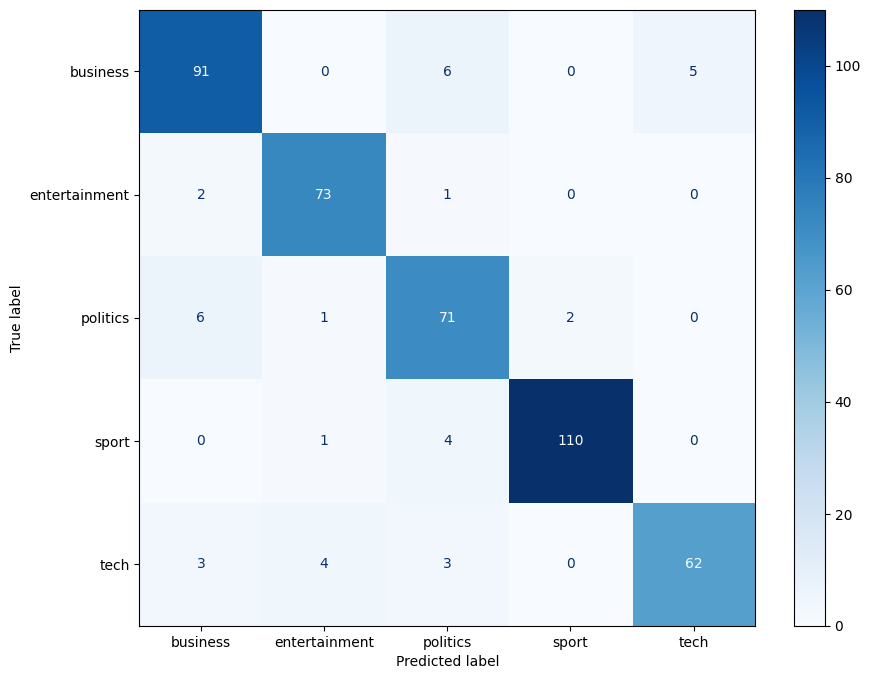

In [116]:
cm = confusion_matrix(y_true, y_pred)

fig, ax = plt.subplots(figsize=(10, 8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.show()

## Testes Qualitativos

In [117]:
tests = [
    "After months of supply issues, the manufacturer renegotiated contracts with two key vendors and rolled out a price increase across its mid-tier line. Management says the move protects margins, but distributors warn demand is already soft. Meanwhile, the company is considering a debt refinance and hinted at a possible divestiture of its logistics unit to “focus on core operations.” Analysts are watching cash flow, inventory turnover, and guidance for next quarter.",
    "The coach rotated the squad heavily ahead of a congested schedule, and the gamble nearly backfired after an early injury forced a tactical switch. A late set-piece decided the match, but the postgame focus turned to workload management and whether the team should rest its star striker for the upcoming rivalry game. Analysts pointed to pressing intensity, defensive transitions, and the keeper’s distribution under pressure.",
    "A cloud provider announced a new feature that automatically scales workloads using predictive models, promising lower latency but raising questions about data handling and vendor lock-in. Developers praise the tooling, yet some teams worry about surprise costs tied to usage-based pricing. The company also patched a widely used library after a vulnerability report, urging customers to rotate keys and update dependencies across CI pipelines.",
    "The studio’s new franchise film opened strong, but online buzz shifted after critics highlighted uneven pacing and heavy product placement. The lead actor’s press tour went viral for an improvised moment that fans are remixing, and streaming platforms are competing for post-theatrical rights. A soundtrack single is climbing charts, while industry insiders debate whether the marketing leaned too hard on nostalgia.",
    "The coalition government avoided a no-confidence vote after agreeing to a revised budget that trims subsidies while expanding targeted aid. Opposition leaders call it austerity by another name and are pushing for an inquiry into procurement practices. The president’s office insists the changes are needed to stabilize the currency, but regional governors want more autonomy over spending. Parliament is set to debate the bill alongside new electoral rules."
]

labels = [
    "business",
    "sport",
    "tech",
    "entertainment",
    "politics"
]

In [118]:
best_model = Model(num_classes=num_classes).to(device)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

for i, (x, y) in enumerate(zip(tests, labels)):
    embedding = preprocess_text_to_embedding(text=x, embedding_model=gensim_embedding_model)
    
    input_tensor = embedding.unsqueeze(0).to(device)
    
    outputs = best_model(input_tensor)
    _, predicted_idx = torch.max(outputs.data, 1)
    
    predicted_category = encoder.inverse_transform(predicted_idx.cpu().numpy())[0]

    result = "✅" if predicted_category == y else "❌"

    print(f"Test Case {i+1}:")
    # print(f"\tText: {fill(x, width=80)}")
    print(f"\tTrue Category: {y}")
    print(f"\tPredicted Category: {predicted_category}")
    print(f"\tResult: {result}\n")

Test Case 1:
	True Category: business
	Predicted Category: business
	Result: ✅

Test Case 2:
	True Category: sport
	Predicted Category: sport
	Result: ✅

Test Case 3:
	True Category: tech
	Predicted Category: tech
	Result: ✅

Test Case 4:
	True Category: entertainment
	Predicted Category: tech
	Result: ❌

Test Case 5:
	True Category: politics
	Predicted Category: politics
	Result: ✅



## Discussão dos Resultados

- **Treino:**

Podemos observar no treino que a curva de perda no conjunto de validação começa a se distanciar da perda do treinamento a partir de um certo ponto, o que indica uma tendência a ter overfitting a partir de um certo número de épocas. Realizei testes com algumas quantidades de épocas e a que melhor chegou num ponto de não dar overfitting foi $120$.

- **Métricas:**

O modelo conseguiu identificar muito bem as classes [**sports**, **entertainment**] onde alcançou métricas acima de $90$%. Já para as classes [**tech**, **business**, **politics**] o modelo obteve resultados piores com métricas abaixo de $90$%.

Em média, o modelo se saiu bem. O modelo possivelmente errou mais para as 3 classes, pois elas contém palavras e contextos parecidos (elas foram as classes que o modelo mais confundiu ao analisarmos a matriz de confusão). Já as classes que ele mais acertou, possuem um contexto com menos intercessão com os demais, além de palavras que já podem ser chaves para definir a classe.

- **Testes Qualitativos:**

O modelo errou apenas um dos testes, que foi justamente nas classes em que ele geralmente mais confunde, o que comprova toda a análise feita anteriormente.